# FlightRadar and Recommendation System -  To buy or not to buy? - supervised classification problem

### Introduction 
Airlines strategy for dynamic tickets pricing is maintained due to the fact that number
of seats to sell changes over the time and they need to maximize its revenue.

The purpose of this project is to study how far we can predict airlines prices change over the time and use it to advice passangers when to buy the ticket or in other words just recommend to buy their ticket or wait.

### Application
To achieve the goal a simple django application working on Openshift architecture has been created allowing to enter departure/arrival destinations with the dates for the following airlines: Wizzair,Ryanair,Easyjet.

Based on the entered criteria system will scrap minimal prices for the selected destinations from the airline website on daily basis. Next using ML models will put its recommandation on the price plot. Historical recommendations in red will indicate wrong decisions based on the new available data, green - "good" ones so far. 

### Model

Models are trained on single flights. The other promising option to train on multiple flights from one segment/vendor requires more data and some extra information about segments which was not avalable here. Training on all flights was tested but it gave worse results which make sense as policy should differ in such cases. 

The following models modes have been implemented:
* BEST_EU/US_PREDICT - Each model trained on individual flights is tested on selected flight. One with the best results of prediction is used to classify current price. A similar flight should fit e.g. in the same segment or policy etc.
* ALL_EU/US_VOTING - Each model trained on individual flights is tested on selected flight. Voting classifier is built of models with score above 80% of custom metric is used to classify current price. Similar flights should fit but some worse models can interfere predictions.
* BEST_EU/US_FIT_AND_PREDICT - similar to BEST_EU/US_PREDICT but trained again on flight we want to predict. Actually "buy!" indicator will not be available during prediction and also it is an information leak as training dataset will have some partial information we want to predict i.e. indicator indicates the change in price till departure and should not be used on the same flight). We are expecting overfitting behaviour here.

### Features selection
The following features have been selected: 
* number of days left until departure, 
* the current day of the week
* the fare price on the previous 7 days normalized by its avarage. 

When scrapping flights data there is no guarantee to have a price on selected day/days common for all other flights to be able compare them. The best we can do when comparing flight prices (influences today's price) when we have only data from 7 days back is to use average and normalize them.   

Although it would be good to have it is difficult to get real amount of unsold seats. This is because in the reservation system it is actually minimum of seats available which means "at least" x seats left. Also the publicly available fare data does not include consolidator and corporate tickets. Therefore, because of that uncertainty, it would be of limited use for training models.

### Classification
There are two classes for each price (for flight and day): 1 - "buy!" or 0 - "wait!".  
The "buy!" is recommended if a model predicts a drop in price in the future below 5% of current price (i.e. it does not make sense to wait and take a risk not buying the ticket at all) or "wait!" otherwise   

### Model evaluation
More accuracy does not usually mean better model as for passanger it might be important to minimize the risk not to buy ticket at all or wait too long and buy too expensive ticket. 
Custom function is used as evaluation method for the model which penalizes it when there was not "to buy" recommandation at all and next in the given order puts pressure on recall of "to buy" instances, then accuracy and recall of "not to buy" instances at the end. This is arbitrary selected requirement and could be changed.

Additionally we want to ensure that we do not recommend "not to buy" if predicted decrease in price is less than 5% of current price.

### Data collection
Flight data are being collected using two strategies. European flight segments minimal prices for the selected destinations are scrapped from the airlines websites on daily basis.
USA flight segment data where scraped from [cheapair](https://www.cheapair.com/when-to-buy-flights/to-philadelphia-phl) site.
Cheapair does not present the historical information in text format, but only in the form of a fare chart. To extract fare data about a segment the graph data from html document has been parsed and feed to custom python parser to transform and scale it. 

### Other
Other models have been analyzed in separate notebooks as time serries or regression and failed as it looks like there is no possibility to learn and predict ticket prices just before departure based on historical data of the same flight only. To find such patterns we need much more data but also look at similar time period before departure and similar flights /same segment, class etc./ and learn on it.


## Importing libraries and load EU flights data from sqlite database
Only flights with full data will be used for training. Others will be used only for predicting

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer,accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import warnings
from sklearn.grid_search import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from collections import namedtuple
from datetime import datetime, timedelta
import glob
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.externals import joblib
from enum import Enum
import traceback
import os
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import AutoDateLocator, DateFormatter,date2num

warnings.filterwarnings("ignore")

connection = sqlite3.connect("./db.sqlite3")
        
sql= """SELECT  
                          carrier.name carrier,
                          CASE WHEN data.returning=1 THEN query.arrival ELSE query.departure END as dpt,
                          CASE WHEN data.returning=1 THEN query.departure ELSE query.arrival END as arr,
                          CASE WHEN data.returning=1 THEN query.returning_date ELSE query.departure_date END as dpt_dt,
                          CASE WHEN data.returning=1 THEN query.departure_date ELSE query.returning_date END as arr_dt,
                          departure_time,
                          arrival_time,                          
                          data.returning,
                          price, created_at
        FROM flightRadar_carrier as carrier
        INNER JOIN flightRadar_searchinput as query
        ON (query.carrier_id=carrier.id)
        INNER JOIN flightRadar_flightdata as data
        ON (query.id=data.search_input_id)"""
df = pd.read_sql(sql, connection)



## Loading US segment flights from disk
Scrapped 7 flights from various USA flight segments - see [FlightPrices_TimeSeries](./FlightPrices_TimeSeries.ipynb) for period of 320 days before departure

In [27]:
Flight = namedtuple("Flight", ["flight","dpt_dt", "data"], verbose=False, rename=False)

datasets=[]
for f in glob.glob("models/*.csv"):
    fd=pd.read_csv(f,header=None,names=['Date','Price']).set_index('Date')
    datasets.append(Flight(flight=f,dpt_dt=fd.index[-1],data=fd['Price'])) 
    print(f)

models/Boston_to_Allentown.csv
models/Albany_to_Philadelphia.csv
models/Flint_to_Syracuse.csv
models/USA_to_Providance.csv
models/USA_to_Philadelphia.csv
models/Rochester_to_Syracuse.csv
models/Boston_to_Providance.csv


In [28]:
datasets[0].data.head()

Date
2017-08-26    366.0
2017-08-27    363.0
2017-08-28    367.0
2017-08-29    371.0
2017-08-30    374.0
Name: Price, dtype: float64

In [29]:
print("Number of all US scrapped flights: %s"%len(datasets))
print("Average of days scrapped: %f"%np.average([len(i.data) for i in datasets]))

Number of all US scrapped flights: 7
Average of days scrapped: 320.000000


## Preprocess EU flight data (filling gaps in data with previous price) and transfer to common format

In [30]:
scraped_datasets=[]
grouped=df.groupby(['carrier','dpt','arr','dpt_dt','arr_dt','departure_time','arrival_time'])
for name, group in grouped:    
    flight=','.join(str(column).replace('0 days ','') for column in name)
    days=group.groupby([df['created_at'].astype(np.datetime64).dt.date])
    XX=[]
    yy=[]   
    for nm, grp in days: 
        XX.append(nm)
        yy.append(grp['price'].mean())
    scraped_datasets.append(Flight(dpt_dt=None,flight=flight,data=pd.Series(yy,XX)))     

#fill gaps in data with previous price

scraped_datasets_processed=[]
def fillGaps(dataset):
    df1=dataset.to_frame()
    df1.index=pd.to_datetime(df1.index)
    df2=pd.DataFrame([],index=[str(d).strip() for d in np.arange(dataset.index.min(),
                               dataset.index.max(),1)])
    df2.index.astype(np.datetime64)
    df3=df1.merge(df2,how="outer", left_index=True, right_index=True)
    
    df3=df3.fillna(method='ffill')
    return df3[0]

for ds in scraped_datasets:
    splited=ds.flight.split(",")
    departure_date=np.datetime64(splited[3])
    scraped_datasets_processed.append(Flight(flight=ds.flight,dpt_dt=departure_date,data=fillGaps(ds.data)))
    

In [31]:
scraped_datasets_processed[5].data.head()

2018-07-30    1795.0
2018-07-31    1795.0
2018-08-01    1795.0
2018-08-02    1795.0
2018-08-03    1618.0
Name: 0, dtype: float64

In [32]:
print("Number of all EU scrapped flights: %s"%len(scraped_datasets_processed))
print("Average of days scrapped: %f"%np.average([len(i.data) for i in scraped_datasets_processed]))


Number of all EU scrapped flights: 55
Average of days scrapped: 22.181818


## Creating utility functions 

In [33]:
class PredictMode(Enum):
    BEST_EU_PREDICT = 0
    BEST_EU_FIT_AND_PREDICT = 1
    ALL_EU_VOTING = 2
    BEST_US_PREDICT = 3
    BEST_US_FIT_AND_PREDICT = 4
    ALL_US_VOTING = 5


In [34]:
#Used from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [35]:
def getSeriesWithDaysBeforeDepartureAndHistoryPrices(dataset,dptDt,lags=7):    
    """
    Prepare futures for forecasting
    Arguments:
        dataset: rough dataset in pandas Series format
        dptDt: departure date as datetime64 
        lags: Number of observations as output (y).
    Returns:
        (X,y) tuple with numpy arrays ready to fit model 
    """
    df = pd.DataFrame()
    df['t'] = [x for x in dataset]
    dataframe = series_to_supervised(df, lags)

    datatime_vect=np.vectorize(np.datetime64)
    try:
        date1=datatime_vect(dataset.index.values)
        date2=datatime_vect(dptDt)
    except:
        date1=dataset.index.values
        date2=dptDt
    daysBDpt=((date2-date1)+1).astype('timedelta64[D]')[lags:]
    dow=[pd.Timestamp(i).dayofweek for i in date1][lags:]
    dataframe.insert(0, 'daysBDpt', pd.Series(daysBDpt.astype(int),index=dataframe.index))
    dataframe.insert(1, 'dow',pd.Series(dow,index=dataframe.index))
    array = dataframe.values
    # split into input and output
    X = array[:,0:-1]
    eps=1e-10

    lag_mean=array[:,2:-1].mean(axis=1)
    #normalize prices to avg before prices
    for i in range(2,lags+2):
        array[:,i]=array[:,i]/lag_mean 
    
    # Create to buy indicator
    #we want to ensure that we do not recommend "not to buy" if predicted decrease in price is less than 5% of current price
    per=0.05 
    y=[ int(np.all(array[i,-1]-per*array[i,-1]<array[i+1:,-1])) \
         for i in range(len(array[:,-1]))] 
    return (X,y)


In [37]:
def custom_score_fun(y_test, y_pred):
    """
    Custom function is used as evaluation method for the model which penalizes it when 
    * there was not "to buy" recommendation at all and 
    * next in the given order puts pressure on recall of "to buy" instances, 
    * then accuracy and 
    * recall of "not to buy" instances at the end.
    """
    fn0 = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0)
    fp1 = precision_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    fn1 = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1) / 1000
    fp0 = precision_score(y_true=y_test, y_pred=y_pred, pos_label=0) / 1000
    main_score = ((fp1 if fn0 == 0 else fn0) + accuracy_score(y_true=y_test, y_pred=y_pred) / 100 + (
        fn1 if fp0 == 0 else fp0))/1.011  #normalize to 1
    if np.count_nonzero(y_pred) == 0 and np.count_nonzero(y_test) > 0:
        return 0
    else:
        return main_score   


## Creating model selection functions

In [38]:
random_state=123
KN=3
models=[
    {"name": "LogisticRegression", "pipeline": make_pipeline(StandardScaler(with_mean=False),LogisticRegression(random_state=random_state))},
    {"name": "MultinomialNB", "pipeline": MultinomialNB()},
    {"name": "DecisionTreeClassifier", "pipeline": DecisionTreeClassifier(random_state=random_state)},
    {"name": "KNeighborsClassifier","pipeline":KNeighborsClassifier(KN)},
    {"name": "LinearDiscriminantAnalysis", "pipeline":LinearDiscriminantAnalysis()},
    {"name": "QuadraticDiscriminantAnalysis","pipeline":QuadraticDiscriminantAnalysis()}    
   ]

params=[
    {"logisticregression__class_weight": ['balanced',None],
     "logisticregression__penalty":["l1","l2"],"logisticregression__C":[0.001,0.01,0.1,1,10,100,1000]},
    {},
    {
     "class_weight": ['balanced',None],
     "criterion":["gini","entropy"],
     'splitter':['best','random'],
     'min_samples_split':[2,5,7,10],
     'max_depth':[2,5,10,100,200,300]},    
    {},
    {},
    {}
   ]


In [39]:
def selectModel(models, params, X_train, X_test, y_train, y_test, splits=3):
    """
    Train and select best model using train,test sets  
    Returns tuple with best model and voting classifier with set of the best classifiers at score 0.8 and more  
    """
    print(y_train)
    print(y_test)
    warnings.filterwarnings("ignore")
    model_name = None
    best_model, best_custom_score, best_rep_score = None, -1, -1
    seed = 123
    try:
        my_cv = KFold(n_splits=splits, random_state=seed)
    except:
        # too few data
        my_cv = KFold(n_splits=2, random_state=seed)

    print(my_cv)
    voting_models = []
    for model, param in zip(models, params):
        try:
            print(model['name'])
            custom_scorer = make_scorer(custom_score_fun, greater_is_better=True)

            gs = GridSearchCV(model['pipeline'], param, scoring=custom_scorer, cv=my_cv, refit=True, n_jobs=1)
            gs.fit(X_train, y_train)

            y_pred = gs.best_estimator_.predict(X_test)
            score = custom_score_fun(y_test, y_pred)
            print("True:", y_test, "Predicted:", y_pred)
            print("Custom score: %s" % score)
            rep = classification_report(y_test, y_pred, target_names=['NOT Buy', 'Buy!'])
            if score > 0.8:
                print("Score %s adding to voting_models %s" % (score, model['name']))
                voting_models.append((model['name'], best_model))
            if score > best_custom_score:
                print("Current best score %s model %s" % (score, model['name']))
                best_model, best_custom_score, best_rep_score, model_name = gs, score, rep, model['name']

        except Exception as e:
            print(e)
    print("Score: %s cust_score %s params %s" % (model_name, best_custom_score, best_model.best_params_))
    print("Report %s", best_rep_score)

    if len(voting_models) == 0: voting_models.append(("best", best_model))
    vot = VotingClassifier(estimators=voting_models, voting="soft")
    vot.fit(X_train, y_train)
    print("VOTING score:")
    y_pred = vot.predict(X_test)
    print(custom_score_fun(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['NOT Buy', 'Buy!']))

    return (best_model, vot)

In [40]:
def testmodels(models,params,flight,dptDt,dataset,**opt):
    """
    Splitting data on training and testing part
    Seleting best models
    """
    print(100*'-')
    print(flight, opt)
    n_test_size=int(0.34*len(dataset))
    print(n_test_size)
    X,y=getSeriesWithDaysBeforeDepartureAndHistoryPrices(dataset,dptDt,opt['lags'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test_size)

    return selectModel(models,params,X_train, X_test, y_train, y_test,opt['splits'])

Data sources format for learning /features,classes/ 

In [50]:
X_,y_=getSeriesWithDaysBeforeDepartureAndHistoryPrices(datasets[0].data,datasets[0].dpt_dt,7)
#days to departure, day of the week, 7 normalized previous prices
X_[:4,:], y_[:4]

(array([[ 313.        ,    5.        ,    0.98652291,    0.97843666,
            0.98921833,    1.        ,    1.00808625,    1.01617251,
            1.02156334],
        [ 312.        ,    6.        ,    0.97319035,    0.98391421,
            0.99463807,    1.00268097,    1.01072386,    1.01608579,
            1.01876676],
        [ 311.        ,    0.        ,    0.97680608,    0.98745247,
            0.99543726,    1.00342205,    1.00874525,    1.01140684,
            1.01673004],
        [ 310.        ,    1.        ,    0.98111069,    0.9890442 ,
            0.99697771,    1.00226672,    1.00491122,    1.01020023,
            1.01548923]]), [0, 0, 0, 0])

## Training models with saving to disk

In [42]:
def train(ids_,typ):
    lags=7
    splits=5

    try:
        best_model,voting_model=testmodels(models,params,ids_.flight,ids_.dpt_dt,ids_.data,lags=lags,splits=splits)
        joblib.dump(best_model, "models/"+os.path.basename(ids_.flight)+"."+typ+".rec")
    except Exception as e:
        print(e)
    
for id in scraped_datasets_processed:
    if (id.dpt_dt<=datetime.date(datetime.now())):
        train(id,"eu")    
    
for id in datasets:
    train(id,"us")    

----------------------------------------------------------------------------------------------------
EasyJet,Kraków,Londyn,2018-07-31,2018-08-29,13:30:00,15:10:00 {'lags': 7, 'splits': 5}
13
[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
KFold(n_splits=5, random_state=123, shuffle=False)
LogisticRegression
True: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1] Predicted: [1 1 0 0 0 0 1 1 0 0 0 1 0]
Custom score: 0.747536711557
Current best score 0.747536711557 model LogisticRegression
MultinomialNB
True: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1] Predicted: [1 1 0 0 0 0 0 1 0 0 1 1 0]
Custom score: 0.498611428137
DecisionTreeClassifier
True: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1] Predicted: [1 1 1 1 0 1 1 1 1 0 0 0 1]
Custom score: 1.0
Score 1.0 adding to voting_models DecisionTreeClassifier
Current best score 1.0 model DecisionTreeClassifier
KNeighborsClassifier
True: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1] Predicted: [1 1 1 1 0 1 0 1 1 0 

True: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0] Predicted: [0 0 1 1 1 0 1 0 0 0]
Custom score: 0.598911968348
Current best score 0.598911968348 model LogisticRegression
MultinomialNB
True: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0] Predicted: [0 1 1 0 0 0 0 0 0 1]
Custom score: 0.597852197259
DecisionTreeClassifier
True: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0] Predicted: [1 1 0 1 0 0 1 0 1 0]
Custom score: 1.0
Score 1.0 adding to voting_models DecisionTreeClassifier
Current best score 1.0 model DecisionTreeClassifier
KNeighborsClassifier
True: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0] Predicted: [1 0 0 1 0 0 1 0 1 0]
Custom score: 0.998846027036
Score 0.998846027036 adding to voting_models KNeighborsClassifier
LinearDiscriminantAnalysis
True: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0] Predicted: [1 1 1 1 0 1 1 0 1 1]
Custom score: 0.403560830861
QuadraticDiscriminantAnalysis
True: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0] Predicted: [1 1 1 1 0 1 1 0 1 1]
Custom score: 0.403560830861
Score: DecisionTreeClassifier cust_score 1.0 params {'class_weight':

VOTING score:
1.0
             precision    recall  f1-score   support

    NOT Buy       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        10

----------------------------------------------------------------------------------------------------
Ryanair,Warszawa-Modlin,Londyn-Stansted,2018-07-26,2018-08-19,21:40:00,23:10:00 {'lags': 7, 'splits': 5}
10
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
KFold(n_splits=5, random_state=123, shuffle=False)
LogisticRegression
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
MultinomialNB
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] Predicted: [1 1 1 1 1 1 1 1 1 1]
Custom score: 1.0
Score 1.0 adding to voting_models MultinomialNB
Current best score 1.0 model MultinomialNB
DecisionTreeClassifier
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] Predicted: [1 1 1 1 1 1 1 1 1 1]
Custom score: 1.0
Score 1.0 adding to voting_models DecisionTreeClassifier
KNeighbo

True: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0] Predicted: [1 0 1 0 0 0 0 1 1 1 1 0 1]
Custom score: 0.55642209203
Current best score 0.55642209203 model LogisticRegression
MultinomialNB
True: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0] Predicted: [1 0 0 1 0 0 0 1 0 1 1 0 1]
Custom score: 0.555543478392
DecisionTreeClassifier
True: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0] Predicted: [1 0 0 0 0 0 0 1 1 0 0 1 1]
Custom score: 0.889336951651
Score 0.889336951651 adding to voting_models DecisionTreeClassifier
Current best score 0.889336951651 model DecisionTreeClassifier
KNeighborsClassifier
True: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0] Predicted: [0 0 0 1 0 0 0 1 1 0 1 0 0]
Custom score: 0.776932376339
LinearDiscriminantAnalysis
True: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0] Predicted: [1 0 0 0 0 1 0 1 0 1 0 0 1]
Custom score: 0.666241852444
QuadraticDiscriminantAnalysis
True: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0] Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Custom score: 0.308377082858
Score: Decisi

True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Custom score: 1.0
Score 1.0 adding to voting_models DecisionTreeClassifier
KNeighborsClassifier
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] Predicted: 

True: [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1] Predicted: [0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0
 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1]
Custom score: 0.972507390797
Score 0.972507390797 adding to voting_models DecisionTreeClassifier
KNeighborsClassifier
True: [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0

VOTING score:
1.0
             precision    recall  f1-score   support

    NOT Buy       1.00      1.00      1.00        75
       Buy!       1.00      1.00      1.00        33

avg / total       1.00      1.00      1.00       108

----------------------------------------------------------------------------------------------------
models/Rochester_to_Syracuse.csv {'lags': 7, 'splits': 5}
108
[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

True: [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1] Predicted: [0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1]
Custom score: 0.982804125726
Score 0.982804125726 adding to voting_models DecisionTreeClassifier
KNeighborsClassifier
True: [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1

## Prediction and ploting utilities

In [102]:
def getBestModel(ids, X, y, X_train, y_train, X_test, y_test, mode, verbose=2):
    """
    Get best model predictions for given flight based on models saved on disk and prediction mode
    Split on train and test for FIT_AND_TRAINING modes
    For other modes predicting on whole data X,y
    """
    estimators = []
    best_score = -1
    best_model = None
    original_best_model = None    

    if mode in [PredictMode.ALL_EU_VOTING,PredictMode.BEST_EU_FIT_AND_PREDICT,PredictMode.BEST_EU_PREDICT]:
        segment="eu"
    else:
        segment="us"


    for f in glob.glob("models/*.%s.rec"%segment):
        fileName = os.path.basename(f)
        flightName = os.path.splitext(f)
        if ids.flight+"."+segment+".rec"==fileName:
            if verbose>0: print("SKIPPED for the same flight") 
        else:
            try:
                model = joblib.load(f)
                y_model_pred = model.predict(X_test)
                model_score = custom_score_fun(y_test, y_model_pred)
                if best_score < model_score:
                    best_score, best_model = model_score, model
                if (model_score>0.8):
                    estimators.append(model)
            except Exception as e:
                if verbose>0: print(e)
    if len(estimators)==0:
        estimators.append(best_model)
    if mode==PredictMode.BEST_EU_FIT_AND_PREDICT or mode==PredictMode.BEST_US_FIT_AND_PREDICT:
        if verbose>1: print("Best model - fitted on test data of target flight") 
        try:    
            best_model.fit(X_train, y_train)    
        except Exception as e:
            if verbose>0: print(e)            
        best_y_pred = best_model.predict(X_test)
        f_best_score = custom_score_fun(y_test, best_y_pred)
        f1__score = f1_score(y_test, best_y_pred)
        try:
            auc_score=roc_auc_score(y_test, best_y_pred)
        except:
            auc_score=0
        rec_score=recall_score(y_test, best_y_pred)
        acc_score=accuracy_score(y_test, best_y_pred)
        if verbose>0: print("Score:", f_best_score)
        if verbose>1: print("True:", y_test)        
        if verbose>1: print("Predicted:", best_y_pred) 
        return (best_model.predict(X)==1,f_best_score,f1__score,auc_score,rec_score,acc_score)

    if mode == PredictMode.BEST_EU_PREDICT or mode == PredictMode.BEST_US_PREDICT:
        if verbose>1: print("Best model - original fitted")
        best_org_y_pred = best_model.best_estimator_.predict(X)
        best_org_score = custom_score_fun(y, best_org_y_pred)
        f1__score = f1_score(y, best_org_y_pred)
        try:
            auc_score=roc_auc_score(y, best_org_y_pred)
        except:
            auc_score=0
        rec_score=recall_score(y, best_org_y_pred)
        acc_score=accuracy_score(y, best_org_y_pred)        
        if verbose>0: print("Score:", best_org_score)
        if verbose>1: print("True:", y)
        if verbose>1: print("Predicted:", best_org_y_pred)
        return (best_org_y_pred==1,best_org_score,f1__score,auc_score,rec_score,acc_score)

    if mode == PredictMode.ALL_EU_VOTING or mode == PredictMode.ALL_US_VOTING:
        if verbose>1: print('Voting hard')
        v = EnsembleVoteClassifier(clfs=estimators, voting="hard", refit=False)
        v.fit(None, np.array([0, 1]))
        try:
            y_pred = v.predict(X)
            voting_score = custom_score_fun(y, y_pred)
            f1__score = f1_score(y, y_pred)
            try:
                auc_score=roc_auc_score(y, y_pred)
            except:
                auc_score=0                
            rec_score=recall_score(y, y_pred)
            acc_score=accuracy_score(y, y_pred)                    
            if verbose>0: print("Score:", voting_score)
            if verbose>1: print("True:", y)
            if verbose>1: print("Predicted:", y_pred)
            return (y_pred==1,voting_score,f1__score,auc_score,rec_score,acc_score)
        except Exception as e:
            if verbose>0: print(e)


In [71]:
def predict(ids_,mode):
    """
    Return predictions for all days in steps:
    1) Prepare features and split by train and test data 
    2) Select best model in given mode
    3) Return predictions
    """
    lags=7
    splits=5

    n_test_size=int(0.34*len(ids_.data))
    print("Predict flight: %s Test size: %s mode: %s"%(ids_.flight,n_test_size,mode))
    if n_test_size>2:
        X_, y_ = getSeriesWithDaysBeforeDepartureAndHistoryPrices(ids_.data, ids_.dpt_dt, lags)
        X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=n_test_size, shuffle=False)

        pred,_,_,_,_,_=getBestModel(ids_, X_, y_, X_train_, y_train_, X_test_, y_test_,mode)
        return pred
    else:
        return []
    


In [69]:
def showPredictions(results,mode=-1):
    """
    Show predictions
    """
    if mode==-1:
        plt.subplots(3, 2,figsize=(13, 20))
    else: 
        plt.figure(figsize=(10, 5))
    for j,prediction in enumerate(PredictMode):
        if mode == -1 or prediction==mode:
            if mode==-1: plt.subplot(3,2, j+1)
            for result in results:
                dataset=result[2]
                plt.plot(dataset, label=result[0])
                plt.xlabel('Date')
                plt.ylabel('Price (zł)')
                ax = plt.gca()
                ax.xaxis.set_major_locator(AutoDateLocator())
                ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
                plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2))
                plt.xticks(rotation=70)
                plt.title('Prices and Recommendations %s'%prediction)

                predictions=predict(result,prediction)

                for i, x in enumerate(reversed(predictions)):
                    #print(i, x, dataset.index[-i - 1])
                    if x:
                        if i==0:
                            fc="orange"
                        elif np.all(dataset.iloc[-i-1] - 0.05 * dataset.iloc[-i-1] < dataset.values[-i-1:]):
                            fc="green"
                        else:
                            fc="red"
                        plt.annotate(
                            "Buy!",
                            xy=(dataset.index[-i-1], dataset.iloc[-i-1]), xytext=(-20, 20),
                            textcoords='offset points', ha='right', va='bottom', size=7 if i!=0 else 10,
                            bbox=dict(boxstyle='round,pad=0.5', fc=fc, alpha=1),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.grid()
    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()

    

# Selecting best model approach and scores: custom score, f1, auc, recall, accuracy

In [94]:
def getDictSortedByValueAsString(dictionary):
    ret=""
    d_view=sorted(dictionary.items(), key=lambda x:x[1])
    d_view.reverse()
    for t in d_view:
        if t[1]>0:
            ret+=str(t[0])+": "+str(t[1])+"\n"
    return ret    

def compareModels(dts,all_models=False, verbose=0):
    f1=dict()
    acc=dict()
    auc=dict()
    rec=dict()
    cust=dict()
    for prediction in PredictMode:
        f1[prediction]=0
        acc[prediction]=0
        auc[prediction]=0
        rec[prediction]=0
        cust[prediction]=0
        
    for dataset in dts:
        if type(dataset.dpt_dt) is str:
            dpt=datetime.date(datetime.strptime(dataset.dpt_dt,'%Y-%m-%d'))
        else:
            dpt=dataset.dpt_dt
        if (dpt<=datetime.date(datetime.now())):
            lags=7
            splits=5

            n_test_size=int(0.34*len(dataset.data))
            if (n_test_size>2):
                if verbose>0: print(100*"*")   
                if verbose>0: print("Flight: %s Test size: %s"%(dataset.flight,n_test_size))
                if verbose>0: print(100*"*")   
                X__, y__ = getSeriesWithDaysBeforeDepartureAndHistoryPrices(dataset.data, dataset.dpt_dt, lags)
                X_train__, X_test__, y_train__, y_test__ = train_test_split(X__, y__, test_size=n_test_size, shuffle=False)

                best_f1_score=-1
                best_rec_score=-1
                best_auc_score=-1
                best_acc_score=-1
                best_cust_score=-1
                best_f1_mode=None
                best_rec_mode=None
                best_auc_mode=None
                best_acc_mode=None    
                best_cust_mode=None    

                for prediction in PredictMode:
                    if all_models or (not prediction in [PredictMode.BEST_EU_FIT_AND_PREDICT, PredictMode.BEST_US_FIT_AND_PREDICT]): 
                        _,cust_score,f1__score,auc_score,rec_score,acc_score=getBestModel(dataset, X__, y__, X_train__, y_train__, X_test__, y_test__,prediction)

                        if verbose>0: print("Mode: %s, cust_score: %s, f1__score: %s, auc_score: %s, rec_score: %s, acc_score: %s"
                              %(prediction,cust_score,f1__score,auc_score,rec_score,acc_score))
                        if best_cust_score<cust_score:     
                            best_cust_score=cust_score
                            best_cust_mode=prediction
                        if best_f1_score<f1__score:
                            best_f1_score=f1__score
                            best_f1_mode=prediction
                        if best_rec_score<rec_score:
                            best_rec_score=rec_score
                            best_rec_mode=prediction            
                        if best_auc_score<auc_score:
                            best_auc_score=auc_score
                            best_auc_mode=prediction
                        if best_acc_score<acc_score:
                            best_acc_score=acc_score
                            best_acc_mode=prediction            
                if verbose>0: print(100*"-")            
                if verbose>0: print("CUSTBest mode: %s, Best score: %s"%(best_cust_mode,best_cust_score))                
                if verbose>0: print("F1  Best mode: %s, Best score: %s"%(best_f1_mode,best_f1_score))
                if verbose>0: print("AUC Best mode: %s, Best score: %s"%(best_auc_mode,best_auc_score))
                if verbose>0: print("REC Best mode: %s, Best score: %s"%(best_rec_mode,best_rec_score))
                if verbose>0: print("ACC Best mode: %s, Best score: %s"%(best_acc_mode,best_acc_score))    
                if verbose>0: print(100*"-")            
                f1[best_f1_mode]+=1
                auc[best_auc_mode]+=1
                rec[best_rec_mode]+=1
                acc[best_acc_mode]+=1
                cust[best_cust_mode]+=1
    print(100*"=")                        
    print("Ranking:")
    print("CUSTOM:\n",getDictSortedByValueAsString(cust))    
    print("F1:\n",getDictSortedByValueAsString(f1))
    print("AUC:\n",getDictSortedByValueAsString(auc))
    print("ACCURACY:\n",getDictSortedByValueAsString(acc))
    print("RECALL\n",getDictSortedByValueAsString(rec))
    print(100*"=")                        


### 1) US flights - only prefitted models

In [103]:
compareModels(datasets,False,1)

****************************************************************************************************
Flight: models/Boston_to_Allentown.csv Test size: 108
****************************************************************************************************
Best model - original fitted
Score: 0.530815976337
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Best model - original fitted
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 

Score: 0.991170605765
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 0 0 0 0 0 0 

Voting hard
Score: 0.703206969587
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 

Best model - original fitted
Score: 0.994467675249
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Pre

Voting hard
Score: 0.993822321207
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 

### All models

In [104]:
compareModels(datasets,True,0)

Best model - original fitted
Score: 0.530815976337
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Pre

Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Voting hard
Score: 0.99113584437
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Voting hard
Score: 0.991170605765
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 

Score: 1.0
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Best model - fitted on test data of target flight
Score: 0.996473971499
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0
 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Voting hard
Score: 0.74989740307
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Voting hard
Score: 0.99021325337
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 0

### 2) EU flights - only prefitted models

In [105]:
compareModels(scraped_datasets_processed,False,1)
    

****************************************************************************************************
Flight: EasyJet,Kraków,Londyn,2018-07-31,2018-08-29,13:30:00,15:10:00 Test size: 13
****************************************************************************************************
SKIPPED for the same flight
Best model - original fitted
Score: 0.994528931751
True: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Mode: PredictMode.BEST_EU_PREDICT, cust_score: 0.994528931751, f1__score: 0.190476190476, auc_score: 0.552631578947, rec_score: 0.105263157895, acc_score: 0.5
SKIPPED for the same flight
Voting hard
Score: 0.559259905743
True: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mode: PredictMode.ALL_EU_VOTING, c

Voting hard
Score: 0.335956650755
True: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0]
Mode: PredictMode.ALL_US_VOTING, cust_score: 0.335956650755, f1__score: 0.642857142857, auc_score: 0.575757575758, rec_score: 0.818181818182, acc_score: 0.565217391304
----------------------------------------------------------------------------------------------------
CUSTBest mode: PredictMode.BEST_EU_PREDICT, Best score: 0.996625223231
F1  Best mode: PredictMode.BEST_US_PREDICT, Best score: 0.642857142857
AUC Best mode: PredictMode.BEST_EU_PREDICT, Best score: 0.681818181818
REC Best mode: PredictMode.BEST_US_PREDICT, Best score: 0.818181818182
ACC Best mode: PredictMode.BEST_EU_PREDICT, Best score: 0.695652173913
----------------------------------------------------------------------------------------------------
****************************************************************************************************
Fligh

Voting hard
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mode: PredictMode.ALL_EU_VOTING, cust_score: 1.0, f1__score: 1.0, auc_score: 0, rec_score: 1.0, acc_score: 1.0
Best model - original fitted
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mode: PredictMode.BEST_US_PREDICT, cust_score: 1.0, f1__score: 1.0, auc_score: 0, rec_score: 1.0, acc_score: 1.0
Voting hard
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mode: PredictMode.ALL_US_VOTING, cust_score: 1.0, f1__score: 1.0, auc_score: 0, rec_score: 1.0, acc_score: 1.0
----------------------------------------------------------------------------------------------------
CUSTBest mode: PredictMode.BEST_EU_PREDICT, Best score: 1.0
F1  Best mode

SKIPPED for the same flight
Voting hard
Score: 0.529877232792
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mode: PredictMode.ALL_EU_VOTING, cust_score: 0.529877232792, f1__score: 0.692307692308, auc_score: 0.5, rec_score: 1.0, acc_score: 0.529411764706
Best model - original fitted
Score: 0.12862434786
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1]
Mode: PredictMode.BEST_US_PREDICT, cust_score: 0.12862434786, f1__score: 0.608695652174, auc_score: 0.451388888889, rec_score: 0.777777777778, acc_score: 0.470588235294
Voting hard
Score: 0.529877232792
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

### All models

In [106]:
compareModels(scraped_datasets_processed,True,0)

SKIPPED for the same flight
Best model - original fitted
Score: 0.994528931751
True: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
SKIPPED for the same flight
Best model - fitted on test data of target flight
Score: 0
True: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0]
SKIPPED for the same flight
Voting hard
Score: 0.559259905743
True: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best model - original fitted
Score: 0.559259905743
True: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best model - fitted on test data of target flight
Score: 0
True: [

Best model - fitted on test data of target flight
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1]
Voting hard
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
SKIPPED for the same flight
Best model - original fitted
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
SKIPPED for the same flight
Best model - fitted on test data of target flight
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1]
SKIPPED for the same flight
Voting hard
Score: 1.0
True: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best model - original fitted
Score: 1.0
True: [1, 1, 1, 1, 1, 

# Summary

As we already expected the good predicting of BEST_EU_FIT_AND_PREDICT is visible both for US and EU segments.
This is most likely due to overfitting which will be reduced in "real" data where we have no future information yet and we expect drop in predictive scores. This could be modeled and tested using time series approach but anyway that has many disadvantages as mentioned at the beginning of this notebook so we will put it "as it is". 

Interestingly ALL_EU_VOTING worked quite well for both US and EU segments but best US (BEST_US_PREDICT) and EU (BEST_EU_PREDICT) models turned out to be the best for their segments.



## Take a look on some predicting charts

Predict flight: Ryanair,Lublin,Londyn-Stansted,2018-07-19,2018-08-16,11:55:00,13:30:00 Test size: 9 mode: PredictMode.ALL_EU_VOTING
SKIPPED for the same flight
Voting hard
Score: 0.62654951379
True: [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted: [1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1]


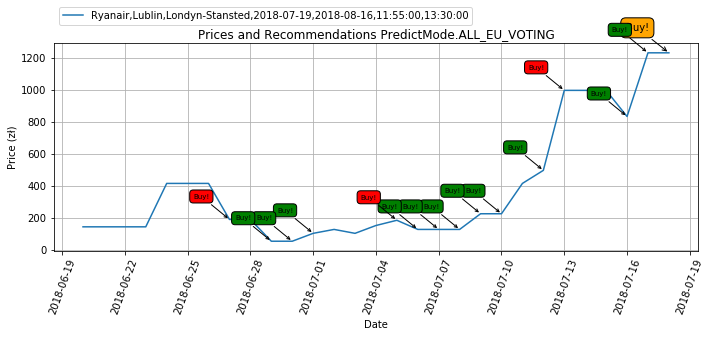

In [107]:
id=scraped_datasets_processed[45]

splited = id.flight.split(",")
departure_date = np.datetime64(splited[3])

showPredictions([Flight(flight=id.flight, dpt_dt=departure_date, data=id.data)],PredictMode.ALL_EU_VOTING) 


Predict flight: Ryanair,Lublin,Londyn-Stansted,2018-07-19,2018-08-16,11:55:00,13:30:00 Test size: 9 mode: PredictMode.BEST_EU_PREDICT
SKIPPED for the same flight
Best model - original fitted
Score: 0.62654951379
True: [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted: [1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1]


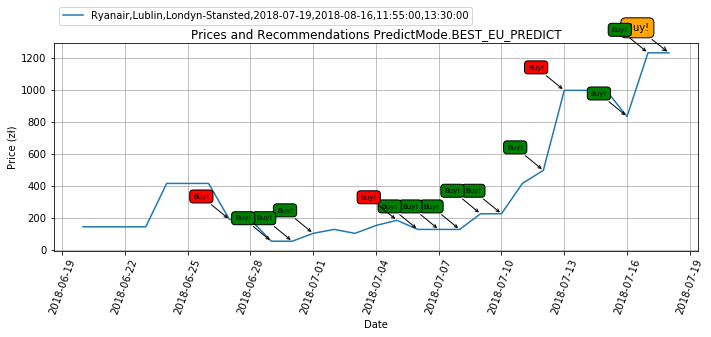

In [108]:
showPredictions([Flight(flight=id.flight, dpt_dt=departure_date, data=id.data)],PredictMode.BEST_EU_PREDICT) 


Predict flight: Ryanair,Lublin,Londyn-Stansted,2018-07-19,2018-08-16,11:55:00,13:30:00 Test size: 9 mode: PredictMode.BEST_EU_FIT_AND_PREDICT
SKIPPED for the same flight
Best model - fitted on test data of target flight
Score: 0.666996373228
True: [1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1]


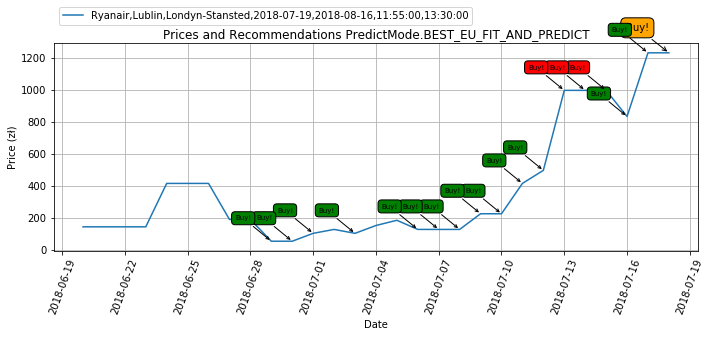

In [109]:
showPredictions([Flight(flight=id.flight, dpt_dt=departure_date, data=id.data)],PredictMode.BEST_EU_FIT_AND_PREDICT) 


Predict flight: Ryanair,Lublin,Londyn-Stansted,2018-07-19,2018-08-16,11:55:00,13:30:00 Test size: 9 mode: PredictMode.ALL_US_VOTING
Voting hard
Score: 0.636723316249
True: [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


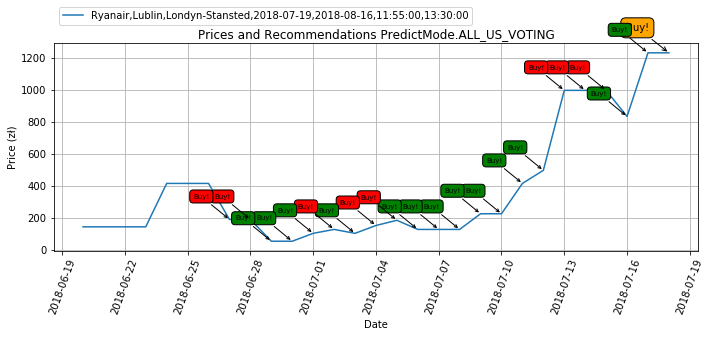

In [110]:
showPredictions([Flight(flight=id.flight, dpt_dt=departure_date, data=id.data)],PredictMode.ALL_US_VOTING) 


Predict flight: Ryanair,Lublin,Londyn-Stansted,2018-07-19,2018-08-16,11:55:00,13:30:00 Test size: 9 mode: PredictMode.BEST_US_PREDICT
Best model - original fitted
Score: 0.636723316249
True: [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


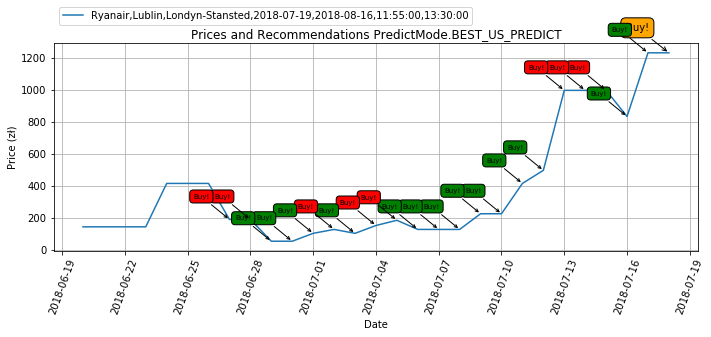

In [111]:
showPredictions([Flight(flight=id.flight, dpt_dt=departure_date, data=id.data)],PredictMode.BEST_US_PREDICT) 


Predict flight: Ryanair,Lublin,Londyn-Stansted,2018-07-19,2018-08-16,11:55:00,13:30:00 Test size: 9 mode: PredictMode.BEST_US_FIT_AND_PREDICT
Best model - fitted on test data of target flight
Score: 0.666996373228
True: [1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted: [1 1 1 1 1 1 1 1 1]


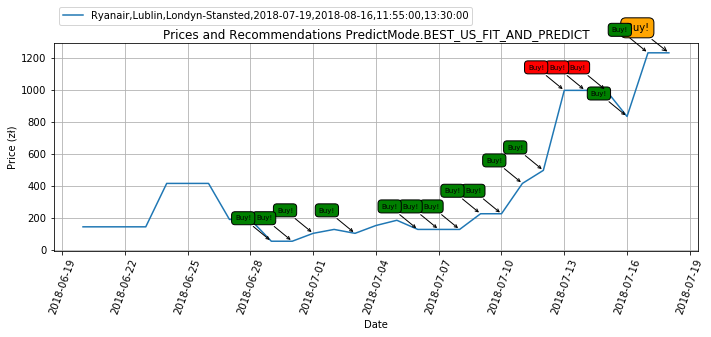

In [112]:
showPredictions([Flight(flight=id.flight, dpt_dt=departure_date, data=id.data)],PredictMode.BEST_US_FIT_AND_PREDICT) 
